# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [2]:
# Load the libraries as required.

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import pickle


In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
fires_dt.head(5)

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
fires_dt.shape

(517, 13)

# Get X and Y

Create the features data frame and target data.

In [6]:
X = fires_dt.drop(columns='area', axis =1) # area is target variable
Y = fires_dt['area']

print(X.shape)
print(Y.shape)

(517, 12)
(517,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(361, 12) (156, 12)
(361,) (156,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [8]:
# Separate catergorical and numerical columns

categorical_features = fires_dt.select_dtypes(include=['object']).columns.tolist()

numerical_features = fires_dt.select_dtypes(include= [float, int]).columns.tolist()

# Remove the 'area' column as it's a target variable
if 'area' in numerical_features:
    numerical_features.remove('area')

print("Categorical Features:")
print(categorical_features)

print("Numerical Features:")
print(numerical_features)

Categorical Features:
['month', 'day']
Numerical Features:
['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [9]:
# Preprocessor 1: Standard scaling and one-hot encoding

preprocessor_simple = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), numerical_features),
        ("onehot", OneHotEncoder(handle_unknown = 'infrequent_if_exist', drop = 'if_binary'), categorical_features)
    ]
)

preprocessor_simple

ColumnTransformer(transformers=[('standard_scaler', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [10]:
# Preprocessor 2: Scaling with non-linear transformation

preprocessor_transform = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("transformer", PowerTransformer())
        ]), numerical_features),
        ("cat", OneHotEncoder(handle_unknown = 'infrequent_if_exist', drop = 'if_binary'), categorical_features)
    ]
)

preprocessor_transform

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('transformer',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [11]:
# Pipeline A = preproc1 + baseline

ridge = Ridge()
pipeline_a = Pipeline(steps=[("preprocessor", preprocessor_simple), ("regressor", ridge)])

pipeline_a

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [12]:
# Pipeline B = preproc2 + baseline

lasso = Lasso()
pipeline_b = Pipeline(steps=[("preprocessor", preprocessor_transform), ("regressor", lasso)])

pipeline_b


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('transformer',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso())])

In [13]:
# Pipeline C = preproc1 + advanced model

random_forest = RandomForestRegressor()
pipeline_c  = Pipeline(steps=[("preprocessor", preprocessor_simple), ("regressor", random_forest)])

pipeline_c


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [14]:
# Pipeline D = preproc2 + advanced model

gradient_boosting = GradientBoostingRegressor()
pipeline_d = Pipeline(steps=[("preprocessor", preprocessor_transform), ("regressor", gradient_boosting)])

pipeline_d
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('transformer',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [15]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each pipeline
param_grid_a = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0]  # Tuning alpha for Ridge in pipeline_a
}

param_grid_b = {
    "regressor__alpha": [0.01, 0.1, 1.0, 10.0]  # Tuning alpha for Lasso in pipeline_b
}

param_grid_c = {
    "regressor__n_estimators": [50, 100, 150, 200]  # Tuning number of estimators for RandomForest in pipeline_c
}

param_grid_d = {
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2]  # Tuning learning rate for GradientBoosting in pipeline_d
}


In [16]:
# Set up grid searches

grid_search_a = GridSearchCV(pipeline_a, param_grid=param_grid_a, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_b = GridSearchCV(pipeline_b, param_grid=param_grid_b, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_c = GridSearchCV(pipeline_c, param_grid=param_grid_c, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_d = GridSearchCV(pipeline_d, param_grid=param_grid_d, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

In [17]:
# Fit grid searches

grid_search_a.fit(X_train, y_train)
grid_search_b.fit(X_train, y_train)
grid_search_c.fit(X_train, y_train)
grid_search_d.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('transformer',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2]},
             scoring='neg_mean_squared_error')

In [18]:
# Collect the best parameters and scores

best_params = {
    "pipeline_a": grid_search_a.best_params_,
    "pipeline_b": grid_search_b.best_params_,
    "pipeline_c": grid_search_c.best_params_,
    "pipeline_d": grid_search_d.best_params_
}

In [19]:
best_scores = {
    "pipeline_a": -grid_search_a.best_score_,
    "pipeline_b": -grid_search_b.best_score_,
    "pipeline_c": -grid_search_c.best_score_,
    "pipeline_d": -grid_search_d.best_score_
}

print("Best Parameters for Each Pipeline:\n", best_params)
print("\nBest Scores (Mean Squared Error) for Each Pipeline:\n", best_scores)

Best Parameters for Each Pipeline:
 {'pipeline_a': {'regressor__alpha': 10.0}, 'pipeline_b': {'regressor__alpha': 1.0}, 'pipeline_c': {'regressor__n_estimators': 50}, 'pipeline_d': {'regressor__learning_rate': 0.01}}

Best Scores (Mean Squared Error) for Each Pipeline:
 {'pipeline_a': 2488.1495414296087, 'pipeline_b': 2351.3572544783074, 'pipeline_c': 2923.5925985532413, 'pipeline_d': 2969.0167106692647}


# Evaluate

+ Which model has the best performance?

In [20]:
# Find the pipeline with the best (lowest) MSE score

best_pipeline = min(best_scores, key=best_scores.get)
best_score = best_scores[best_pipeline]

print(f"The best-performing pipeline is {best_pipeline} with an MSE of {best_score:.2f}.")


The best-performing pipeline is pipeline_b with an MSE of 2351.36.


Pipeline B = preproc2 + baseline (lasso regressor)

# Export

+ Save the best performing model to a pickle file.

In [21]:
# Export best model as pickle file

best_forest_fire_model = pipeline_b
file_path = '../../05_src/best_forest_fire_model.pkl'

with open("file_path", "wb") as file:
    pickle.dump(best_forest_fire_model, file)



# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

*(Answer here.)*

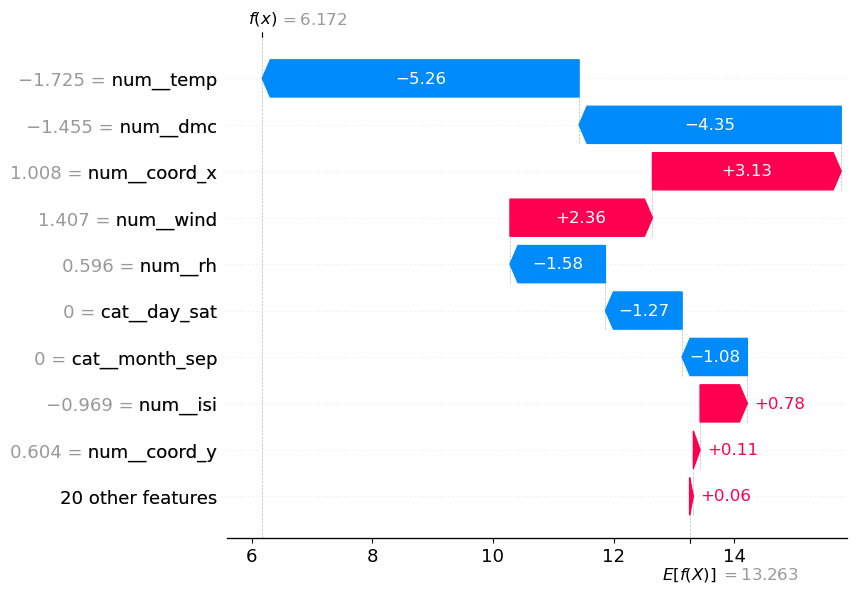

In [50]:
import shap.explainers

best_model = pipeline_b.fit(X,Y)
data_transform = best_model.named_steps['preprocessor'].transform(X)

regressor_model = best_model.named_steps['regressor']

# # Get feature names after transformation
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.explainers.Linear(
    regressor_model, 
    data_transform,
    feature_names = feature_names)

shap_values = explainer(data_transform)
shap.plots.waterfall(shap_values[0],max_display=10, show=True)

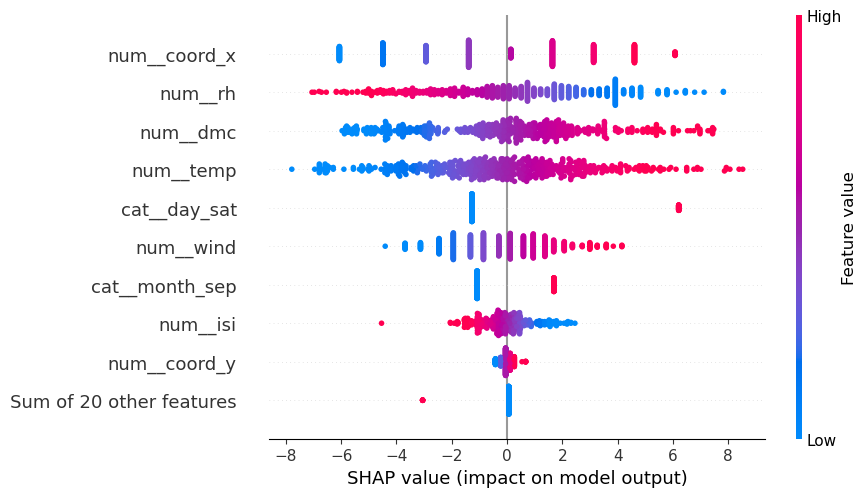

In [44]:
shap.plots.beeswarm(shap_values)

I observe that coord_x and wind have a positive impact on the prediction, while temp and dmc are negatively affecting it.

If I decide to remove some features, I will focus on those with significant and minimal SHAP values, as they are likely to contribute to a lower prediction value. In this case, features such as rh, day_sat, and month_sept are negatively impacting the prediction.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.